# Acoustic localization

Acoustic localization is a method for identifying the location of a sound-source, based on the time delays of arrival (TDOAs) between multiple time-synchronized audio recordings. This notebook outlines how you can use Opensoundscape's localization module to for acoustic localization. There are multiple steps involved in using an array of audio receivers to identify sound source locations. These include: 

1. Deploying time-synchronizable recording devices at static, known locations. 
2. Synchronizing recordings. 
3. Labeling the detections of your sound of interest in the audio. 
4. Estimating the time delays of arrival (TDOAs) of the sound of interest between multiple microphones.
5. Localizing the sound source from TDOAs.
6. Assessing the confidence of these localizations.

This notebook will focus mostly on steps 3 onwards, as the details of steps 1 and 2 depend on your choice of hardware.

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/acoustic_localization.ipynb) | The link opens the tutorial in Google Colab. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/acoustic_localization.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

## Setup

### Import packages

In [154]:
# import the packages we'll use
import opensoundscape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
from typing import List, Dict, Tuple, Optional
import geopandas as gpd


%config InlineBackend.figure_format = 'retina'

In [155]:
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR environment variable is not set.")

# Prep data for tutorial

##### ❗ NOTE
Some of the recordings started 1 or 2 sec after the true time for some reason, as can be seen in filenames like: B_20240702_002802.WAV

To fix this, we add a corresponding amount of white noise a the start of files where this happened.

In [156]:
audio_dir = os.path.join(BASE_DIR, "bomb_fishing/data/estimating_distance/blast_2")

def pad_with_noise(audio_dir: str) -> None:
    """Pad WAVs in `audio_dir` with white noise based on the seconds in their filename,
    but skip any file that’s exactly 57 s long."""
    for fname in os.listdir(audio_dir):
        if not fname.upper().endswith(".WAV"):
            continue

        path = os.path.join(audio_dir, fname)
        # check duration without loading full audio
        info = sf.info(path)
        duration = info.frames / info.samplerate
        if abs(duration - 57) < 1e-3:
            print(f"Skipping {fname}: duration is {duration:.2f}s")
            continue

        # parse seconds offset from filename timestamp
        try:
            ts = os.path.splitext(fname)[0].split("_")[-1]
            offset = int(ts[-2:])
        except (IndexError, ValueError):
            print(f"Skipping {fname}: cannot parse timestamp")
            continue

        if offset <= 0:
            continue  # nothing to do

        # load audio and prepend white noise
        data, sr = sf.read(path)
        n_samples = offset * sr
        if data.ndim == 1:
            noise = np.random.randn(n_samples)
            out = np.concatenate((noise, data))
        else:
            noise = np.random.randn(n_samples, data.shape[1])
            out = np.vstack((noise, data))

        sf.write(path, out, sr)
        print(f"Padded {fname} with {offset}s of noise")


pad_with_noise(audio_dir)

Padded B_20240702_002802.WAV with 2s of noise


### Make aru_coords csv
Convert recorder coordinates to OpenSoundscapes UTM format

In [157]:
# Recorder positions (latitude, longitude)
a_coords_geo: List[Tuple[float, float]] = [
    (-4.70878, 119.32657),  # A
    (-4.80363, 119.32858),  # B
    (-4.92992, 119.31595),  # C
    #(-5.07711, 119.31749),  # D we don't use D
]

# Access the list of recorder positions
df_coords = pd.DataFrame(a_coords_geo, columns=["lat","lon"], index=["A","B","C"])

# Convert to a GeoDataFrame 
gdf_coords = gpd.GeoDataFrame(
    df_coords, 
    geometry=gpd.points_from_xy(df_coords.lon, df_coords.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)      # Web-Mercator


# Now extract X,Y in metres
aru_coords_mapping = gdf_coords.copy()
aru_coords_mapping["x"] = aru_coords_mapping.geometry.x
aru_coords_mapping["y"] = aru_coords_mapping.geometry.y
aru_coords_mapping = aru_coords_mapping[["x","y"]] 

# now write to csv site_coords
site_coords = os.path.join(BASE_DIR, "bomb_fishing/code/localisation/site_coords.csv")
aru_coords_mapping.to_csv(site_coords, index=False)


Now we build aru_coords csv using the aru_coords_mapping and detections.csv

In [158]:
# Load detections.csv
detections_csv = os.path.join(
    BASE_DIR, "bomb_fishing", "code", "localisation", "detections.csv"
)
# Load as a df with columns as floats to match the tutorial's data 
detections = pd.read_csv(
    detections_csv,
    dtype={"start_time": float, "end_time": float, "blast": float},
)

# Build the ARU coords CSV in the tutorials format
# 1. One row per unique file
aru_coords = pd.DataFrame({"file": detections["file"].unique()})
# 2. Extract A/B/C prefix by rremoving the path and taking the first char
aru_coords["site"] = aru_coords["file"].str.split("/").str[-1].str[0]

# 3. Join with metre‐coords (aru_coords_mapping: index A/B/C → x,y)
coords_df = aru_coords_mapping.reset_index().rename(columns={"index": "site"})
aru_coords = (
    aru_coords
      .merge(coords_df, on="site", how="left")
      .drop(columns="site")            # only keep file, x, y
      .set_index("file")               # filenames become the first (unnamed) column
)
# The tutorial uses file as the index which is a bit confusing, so now we have set this
# as the index, remove the index column header.
aru_coords.index.name = None      

# 4. Rebase so coords are relative to the first ARU
origin = aru_coords.iloc[0]
aru_coords[["x", "y"]] = aru_coords[["x", "y"]].subtract(origin)

# 5. Write out to csv
out_path = os.path.join(
    BASE_DIR, "bomb_fishing", "code", "localisation", "aru_coords.csv"
)
aru_coords.to_csv(out_path, float_format="%.6f")

# 6. Quick check to confirm tutorial‐style format
aru_check = pd.read_csv(out_path)
aru_check.head()


,Unnamed: 0,x,y
0,/home/bwilliams/ucl_projects/bomb_fishing/data...,0.000000,0.000000
1,/home/bwilliams/ucl_projects/bomb_fishing/data...,223.752176,-10595.138981
2,/home/bwilliams/ucl_projects/bomb_fishing/data...,-1182.212992,-24704.549573


## Read in receiver coordinates

Our pipeline begins with a set of time-synchronized audio files, 1 from each receiver (ARU). For each audio file, we know the position of each receiver, measured in meters. These were measured using UTM originally, then the coordinates of R1 were subtracted from all of the points for readability and numerical stability. 

We use this information to initialize a `SynchronizedRecorderArray` object.

In [159]:
# aru_coords = pd.read_csv(
#     os.path.join(BASE_DIR, "bomb_fishing/scratch/localization_files/aru_coords.csv"),
#     index_col=0
# )  # a dataframe wih index "/path/to/audio/file" and columns "x" and "y" coordinates of the ARU
# aru_coords

In [160]:
aru_coords = pd.read_csv(
    os.path.join(BASE_DIR, "/home/bwilliams/ucl_projects/bomb_fishing/code/localisation/aru_coords.csv"),
    index_col=0
)  # a dataframe wih index "/path/to/audio/file" and columns "x" and "y" coordinates of the ARU
aru_coords

,x,y
/home/bwilliams/ucl_projects/bomb_fishing/data/estimating_distance/blast_2/A_20240702_002800.WAV,0.000000,0.000000
/home/bwilliams/ucl_projects/bomb_fishing/data/estimating_distance/blast_2/B_20240702_002802.WAV,223.752176,-10595.138981
/home/bwilliams/ucl_projects/bomb_fishing/data/estimating_distance/blast_2/C_20240702_002800.WAV,-1182.212992,-24704.549573


In [161]:
# initialize a SynchronizedRecorderArray with the ARU coordinates
from opensoundscape.localization import SynchronizedRecorderArray

array = SynchronizedRecorderArray(
    aru_coords, # pass it the df from earlier
    speed_of_sound=1541.0
)

The SynchronizedRecorderArray object we've created will now be used to localize a set of 'detections'. These are in the file `detections.csv`. They are a set of binary detections for every receiver in the array. For each time-window (in our case we used 3 second time-windows), every receiver either contains (1) or does not contain (0) our sounds of interest. These detections could be generated by using an automated classifier, like a CNN or RIBBIT (see our other tutorials for more information), or by manual listening. It's fine if multiple species are detected in the same time-window, on the same receiver. Though you should be aware that the busier the soundscape, the harder it will be for acoustic localization.

In [162]:
# load a dataframe with species detections,
# such as one created with machine learning model thresholded outputs

detections_tutorial = pd.read_csv("/home/bwilliams/ucl_projects/bomb_fishing/scratch/localization_files/detections.csv")
detections_tutorial

,file,start_time,end_time,Black-throatedBlueWarbler,ScarletTanager,Black-throatedGreenWarbler,Black-and-whiteWarbler,AcadianFlycatcher
0,R2_M11-1459_MSD-1657_20220207_191236_callibrat...,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,R2_M11-1459_MSD-1657_20220207_191236_callibrat...,3.0,6.0,0.0,0.0,0.0,0.0,0.0
2,R2_M11-1459_MSD-1657_20220207_191236_callibrat...,6.0,9.0,1.0,0.0,0.0,0.0,0.0
3,R2_M11-1459_MSD-1657_20220207_191236_callibrat...,9.0,12.0,1.0,0.0,0.0,0.0,0.0
4,R2_M11-1459_MSD-1657_20220207_191236_callibrat...,12.0,15.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
166,R5_M11-1464_MSD-1651_20220207_191552_callibrat...,42.0,45.0,0.0,0.0,0.0,0.0,0.0
167,R5_M11-1464_MSD-1651_20220207_191552_callibrat...,45.0,48.0,0.0,0.0,0.0,0.0,0.0
168,R5_M11-1464_MSD-1651_20220207_191552_callibrat...,48.0,51.0,0.0,0.0,0.0,0.0,0.0
169,R5_M11-1464_MSD-1651_20220207_191552_callibrat...,51.0,54.0,0.0,0.0,1.0,1.0,0.0


In [163]:
detections_path = os.path.join(
    BASE_DIR,
    "bomb_fishing/code/localisation/detections.csv"
)
detections = pd.read_csv(
    detections_path,
    dtype={
        "start_time": float,
        "end_time": float,
        "blast": float,
        "file": str,
    })
detections

,file,start_time,end_time,blast
0,/home/bwilliams/ucl_projects/bomb_fishing/data...,0.0,30.0,0.0
1,/home/bwilliams/ucl_projects/bomb_fishing/data...,30.0,60.0,1.0
2,/home/bwilliams/ucl_projects/bomb_fishing/data...,0.0,30.0,0.0
3,/home/bwilliams/ucl_projects/bomb_fishing/data...,30.0,60.0,1.0
4,/home/bwilliams/ucl_projects/bomb_fishing/data...,0.0,30.0,0.0
5,/home/bwilliams/ucl_projects/bomb_fishing/data...,30.0,60.0,1.0


#### Try the padded silence trick
Why:
1. Open soundscape (OS) needs detections to be put into windows. E.g the tutorial has 3sec windows.
2. However, when you calling localize_detections(), it computes a “search window” of [start_time – max_delay  …  end_time + max_delay]
where: max_delay = max_receiver_dist / speed_of_sound.
3. If your WAV is shorter than that full interval, OS warns and silently skips the event (hence you got an empty list).
4. To fix, calculated the largest timestamp OS will request in the cell below and padd each audio file so its total length ≥ target_duration.

So we pad the audio in this cell below

In [170]:
import os
import numpy as np
import soundfile as sf

MAX_RECEIVER_DIST = 24700.0  # metres
SPEED_OF_SOUND = 1541.0      # m/s

# 1. Compute max_delay
max_delay = MAX_RECEIVER_DIST / SPEED_OF_SOUND

# 2. Get the latest detection end_time (in seconds)
max_end = detections.reset_index()["end_time"].max()

# 3. How long each file must be
target_duration = max_end + max_delay

print(f"Need files ≥ {target_duration:.1f}s long (end_time {max_end}s + delay {max_delay:.1f}s)")

# 4. Pad each WAV in place to at least that length
for fname in os.listdir(audio_dir):
    if not fname.lower().endswith(".wav"):
        continue
    path = os.path.join(audio_dir, fname)
    data, sr = sf.read(path)
    duration = len(data) / sr
    
    # only pad if it’s too short
    if duration >= target_duration:
        print(f"{fname}: OK ({duration:.1f}s ≥ {target_duration:.1f}s)")
        continue
    
    pad_needed = target_duration - duration
    pad_samples = int(np.ceil(pad_needed * sr))
    pad_shape = (pad_samples,) if data.ndim == 1 else (pad_samples, data.shape[1])
    pad = np.zeros(pad_shape, dtype=data.dtype)
    
    sf.write(path, np.concatenate([data, pad], axis=0), sr)
    print(f"Padded {fname}: {duration:.1f}s → { (len(data)+pad_samples) / sr :.1f}s")


Need files ≥ 76.0s long (end_time 60.0s + delay 16.0s)
Padded A_20240702_002800.WAV: 62.1s → 76.0s
Padded B_20240702_002802.WAV: 64.1s → 76.0s
Padded C_20240702_002800.WAV: 62.1s → 76.0s


##### Continue tutorial...

In [171]:
# load a dataframe with species detections
# Read in every column as str or float as appropriate to match the tutorial
detections_path = os.path.join(
    BASE_DIR,
    "bomb_fishing/code/localisation/detections.csv"
)
detections = pd.read_csv(
    detections_path,
    dtype={
        "start_time": float,
        "end_time": float,
        "blast": float,
        "file": str,
    })

# add information about the real-world timestamps, if the audio files don't have
# start timestamps embedded in the metadata
# in this case, when we synchronized the audio files we trimmed all of them to start
# at the same start time, and we can add that here
# Note: if your audio files have embedded start timestamps that can be loaded into
# Audio.metadata['recording_start_time'] as a localized timestamp, you don't need to
# create this column
import pytz
from datetime import datetime, timedelta

local_timestamp = datetime(2024, 7, 2, 0, 28, 0)
local_timezone = pytz.timezone("Asia/Makassar")
detections["start_timestamp"] = [
    local_timezone.localize(local_timestamp) + timedelta(seconds=s)
    for s in detections["start_time"]
]

# set four columns as a multi-index, to match format expected for localization
detections = detections.set_index(["file", "start_time", "end_time", "start_timestamp"])

detections.head()

blast
file                                               start_time end_time start_timestamp                 
/home/bwilliams/ucl_projects/bomb_fishing/data/... 0.0        30.0     2024-07-02 00:28:00+08:00    0.0
                                                   30.0       60.0     2024-07-02 00:28:30+08:00    1.0
/home/bwilliams/ucl_projects/bomb_fishing/data/... 0.0        30.0     2024-07-02 00:28:00+08:00    0.0
                                                   30.0       60.0     2024-07-02 00:28:30+08:00    1.0
/home/bwilliams/ucl_projects/bomb_fishing/data/... 0.0        30.0     2024-07-02 00:28:00+08:00    0.0

## Localize detections
We need to set two parameters before we can try and localize these sounds. They are:

- `min_n_receivers` : The minimum number of receivers that a sound must be detected on for localization to be attempted. Must be at least n+2 to localize a point in n dimensions. If you have a dense localization grid and expect your sound to be heard on more receivers, you can increase this number and it may improve the precision of location estimates.
- `max_receiver_dist` : Time delays of arrival (TDOAs) are estimated between pairs of receivers. Only receivers within `max_receiver_dist` of each other will be used for TDOA estimation. If `max_receiver_dist`=100, then if 2 receivers >100 apart both contain detections of the same sound, a TDOA will not be estimated between them. This is useful for separating out multiple simultaneous sounds at different locations if you are deploying a large array.

In [172]:
# parameters for localization
position_estimates = array.localize_detections(
    detections,
    min_n_receivers=3, # min_number of receivers for a detection to be localized
    max_receiver_dist=24700, # maximum distance between receivers
    cc_threshold=0.0,        # allow even weak correlations
)

The method `array.localize_detections` returns a list of `PositionEstimate` objects. Each of these contains all the information used to estimate a location of a sound event. There is a lot of redundancy in these objects, i.e. for any given individual sound-event, we expect there to be multiple `PositionEstimate` objects, each with their own estimate of the position. Here's an outline for how these SpatialEvents are generated. 

For every receiver within a time-window that has a detection, we:

- Choose one receiver with a detection to be the central 'reference receiver'. Every other receiver that also has a detection of the same sound class, and is within `max_receiver_dist` of this reference receiver will  be included in the `PositionEstimate` object. The reference receiver will be the first receiver in the list of `receiver_files` stored in the `PositionEstimate.receiver_files` attribute.
- Cross-correlation is used to estimate the TDOA between the reference receiver, and all the other receivers included in the `PositionEstimate` object. The cross-correlations, and TDOAs are saved as the attributes `PositionEstimate.cc_maxs` and `PositionEstimate.tdoas`.
- A localization algorithm finds a solution given the TDOAs, and estimates the location of the sound source. This is saved in the `PositionEstimate.location_estimate` attribute.

In this way, each SpatialEvent provides an estimate of the sound source location, based on the TDOAs estimated against a different reference receiver. There are multiple SpatialEvents even for the same single sound-event, because we can estimate the location trying to use multiple different receivers as the central 'reference receiver'.

Let's take a look at some of the attributes of these objects below - using the first `PositionEstimate` object as an example.

In [181]:
example = position_estimates[0]
print(f"The start time of the detection: {example.start_timestamp}")
print(f"This is a detection of the class/species: {example.class_name}")
print(
    f"The duration of the time-window in which the sound was detected: {example.duration}"
)
print(f"The estimated location of the sound: {example.location_estimate}")
print(f"The receivers on which our species was detected: \n{example.receiver_files}")
print(f"The estimated time-delays of arrival: \n{example.tdoas}")
print(f"The normalized Cross-Correlation scores: \n{example.cc_maxs}")

The start time of the detection: 2024-07-02 00:28:30+08:00
This is a detection of the class/species: blast
The duration of the time-window in which the sound was detected: 30.0
The estimated location of the sound: [ -2331.68685119 -17985.98770425]
The receivers on which our species was detected: 
['/home/bwilliams/ucl_projects/bomb_fishing/data/estimating_distance/blast_2/B_20240702_002802.WAV'
 '/home/bwilliams/ucl_projects/bomb_fishing/data/estimating_distance/blast_2/A_20240702_002800.WAV'
 '/home/bwilliams/ucl_projects/bomb_fishing/data/estimating_distance/blast_2/C_20240702_002800.WAV']
The estimated time-delays of arrival: 
[ 0.         12.98707211 -0.71267789]
The normalized Cross-Correlation scores: 
[1.         0.09840085 0.11376011]


Visualize the estimated position from this SpatialEvent

/home/bwilliams/anaconda3/envs/open_soundscape_env/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


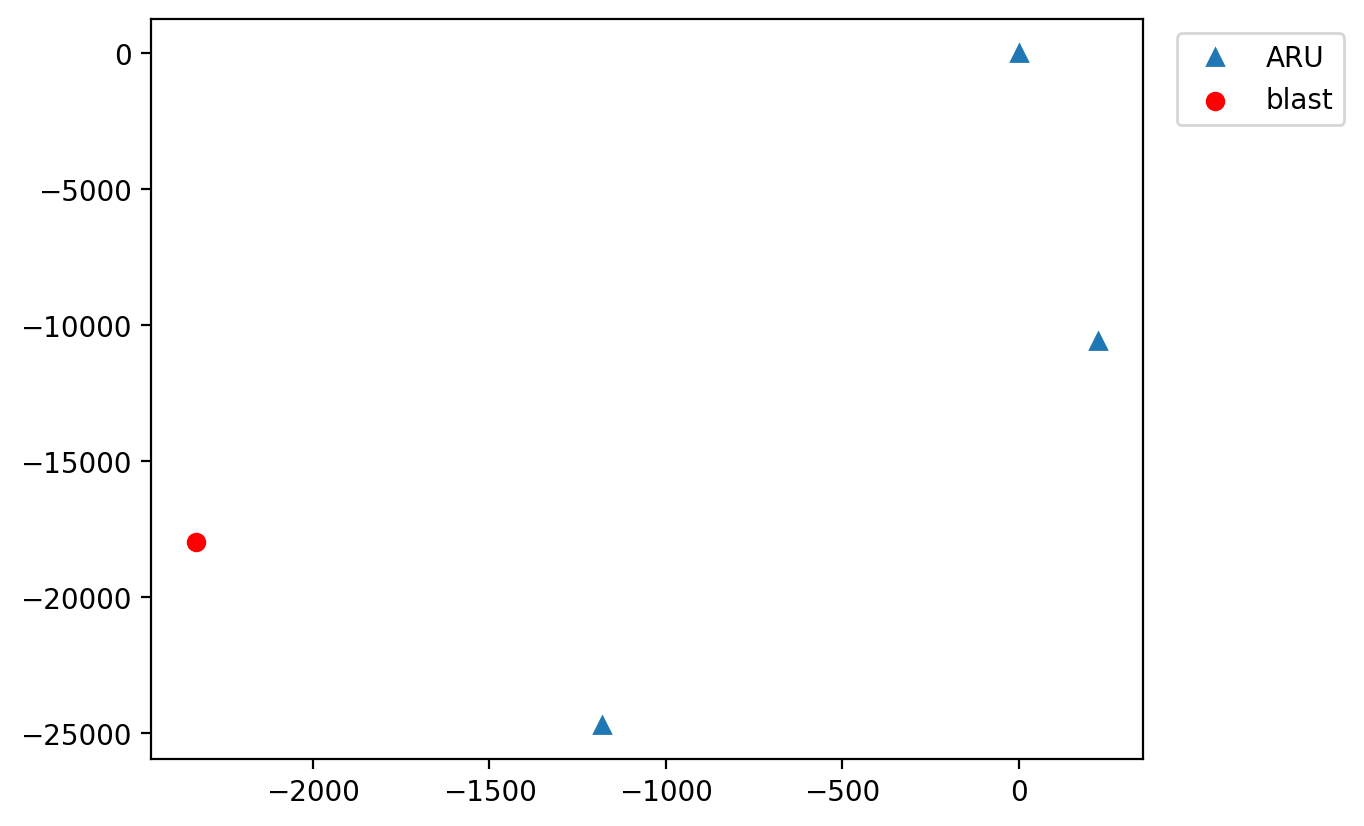

In [175]:
plt.plot(aru_coords["x"], aru_coords["y"], "^", label="ARU")
plt.scatter(
    x=example.location_estimate[0],
    y=example.location_estimate[1],
    color="red",
    label=f"{example.class_name}",
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

Check if cross correlation estimated the correct tdoa values by checking for alignment of the signal in the audio clips after offsetting by tdoa:

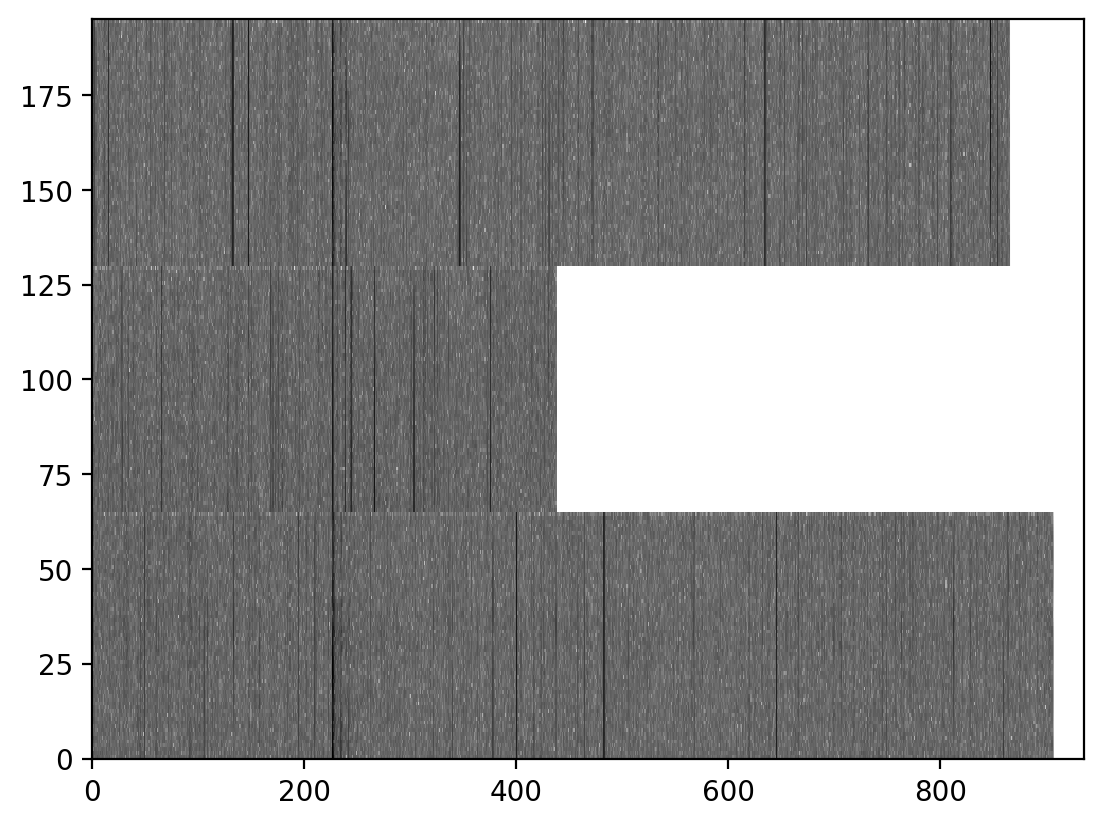

In [176]:
from opensoundscape import Spectrogram

audio_segments = example.load_aligned_audio_segments()
specs = [Spectrogram.from_audio(a).bandpass(3000, 7000) for a in audio_segments]
plt.pcolormesh(np.vstack([s.spectrogram for s in specs]), cmap="Greys")

The target sound, the Black-throated Blue Warbler song, is not aligned in time across the spectrograms, indicating that cross correlation failed to correctly align the files and estimate the time of arrival differences for the recorders. This might bebecause there are multiple distinct, loud forground sounds from different sources. 

We can often filter out such errors by checking the residuals of the localization algorithm: the difference between the expected distances to sources based on the position estimate and the distances to the sources required to match the tdoa. Here, the root-mean-square value of residuals across recorders is huge (>30m), so we can filter this out as an incorrect result. 

In [177]:
example.residual_rms

5598.68110541799

But we have multiple different estimates for the event, given by the different SpatialEvents. So we can plot all the location estimates in this time-window for Black-throated blue warbler. Given the small size of this array, these are all likely estimates of the same bird singing. In fact in this case, we used a speaker to broadcast the sounds, so we know there was only one sound source. So the multiple dots on the plot below give us multiple estimates of the same the single sound event, each using a different ARU as the reference receiver. Ideally the position estimates would all be in the same place, and we'd be confident we're localizing a single bird with high precision. In fact, we see that the estimates are all over the place!

Let's color the estimates by the root-mean-square of the residual to get a sense for how self-consistent they are.

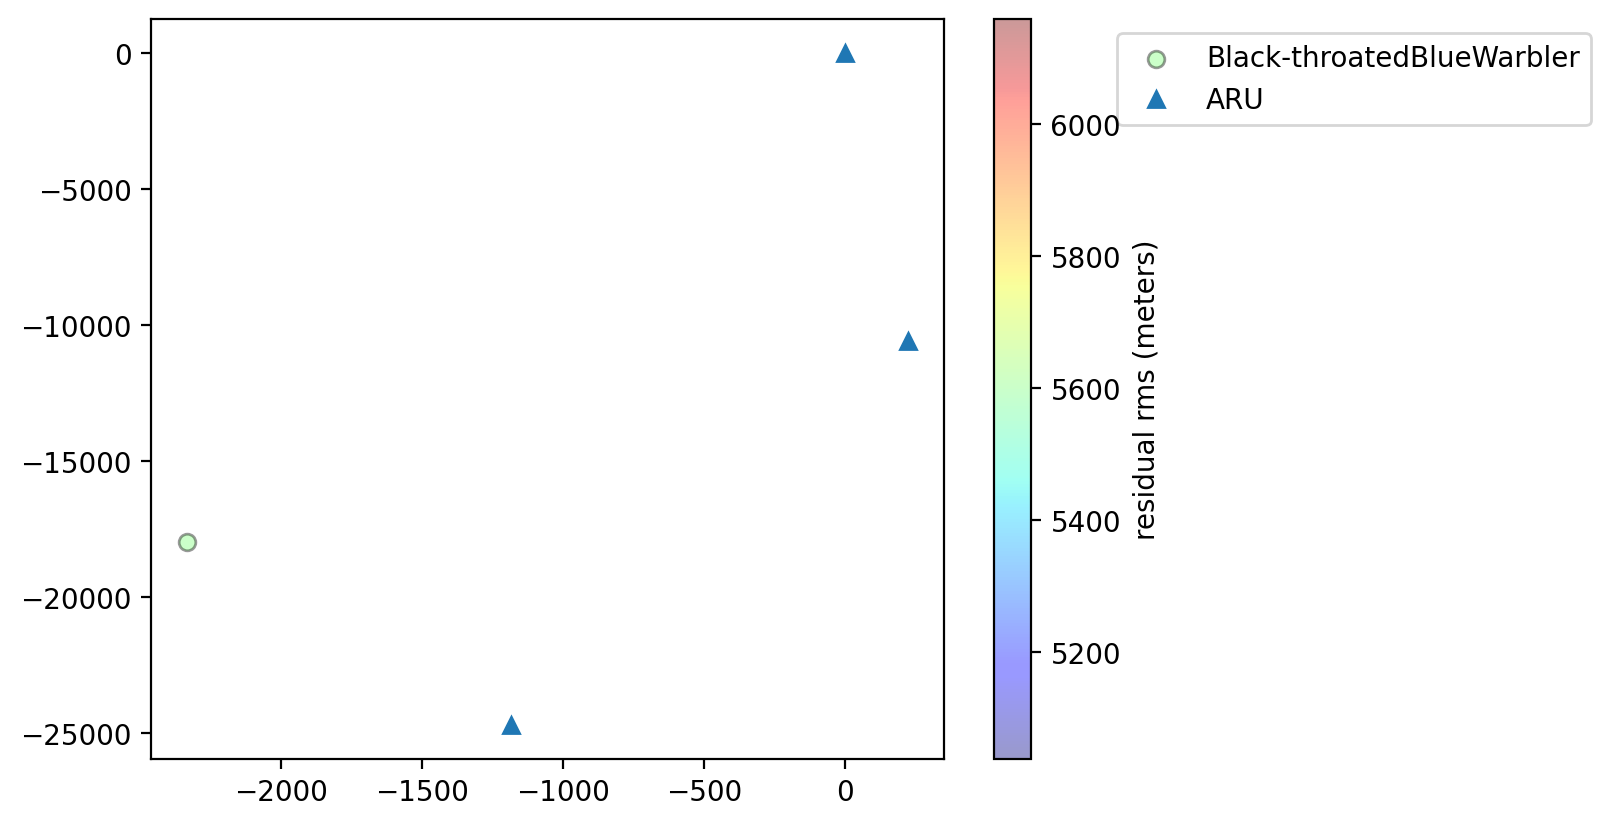

In [ ]:
# get all the SpatialEvents in this time-window attributed to Black-throatedBlueWarbler
black_throated_blue_warblers = [
    e
    for e in position_estimates
    if e.class_name == example.class_name
    and e.start_timestamp == example.start_timestamp
]
# get the x-coordinates of the estimated locations
x_coords = [e.location_estimate[0] for e in black_throated_blue_warblers]
# get the y-coordinates of the estimated locations
y_coords = [e.location_estimate[1] for e in black_throated_blue_warblers]
# get the rms of residuals per event
rms = [e.residual_rms for e in black_throated_blue_warblers]
# plot the estimated locations, colored by the residuals
plt.scatter(
    x_coords,
    y_coords,
    c=rms,
    label="Blast",
    alpha=0.4,
    edgecolors="black",
    cmap="jet",
)
cbar = plt.colorbar()
cbar.set_label("residual rms (meters)")
# plot the ARU locations
plt.plot(aru_coords["x"], aru_coords["y"], "^", label="ARU")
# make the legend appear outside of the plot
plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left")

## Filter out bad localizations

One of the reasons we have multiple estimated positions that disagree with each other, is we did not filter the estimated positions by any measure of confidence in the estimated position. An error metric we can use is to look at how well the measured TDOAs between the receivers match the estimated position. To summarize this in a single metric, we use the root-mean square (or L2 norm) of the TDOA residuals (measured in meters). This is a single number, that gives a measure of how well the time-delays agree with what we would expect given the estimated location. You can access the `residual_rms` attribute of the `SpatialEvent` object to get this number.

A `residual_rms` of less than 5m suggests a sound-source location has been estimated with high precision. We can filter out the high-error SpatialEvents and plot only the precise ones. As these recordings actually came from a speaker playing recordings of a Black-throated Blue Warbler, we can compare this estimated position of thes to the true known position. Which was `-86.440, 58.861`. 

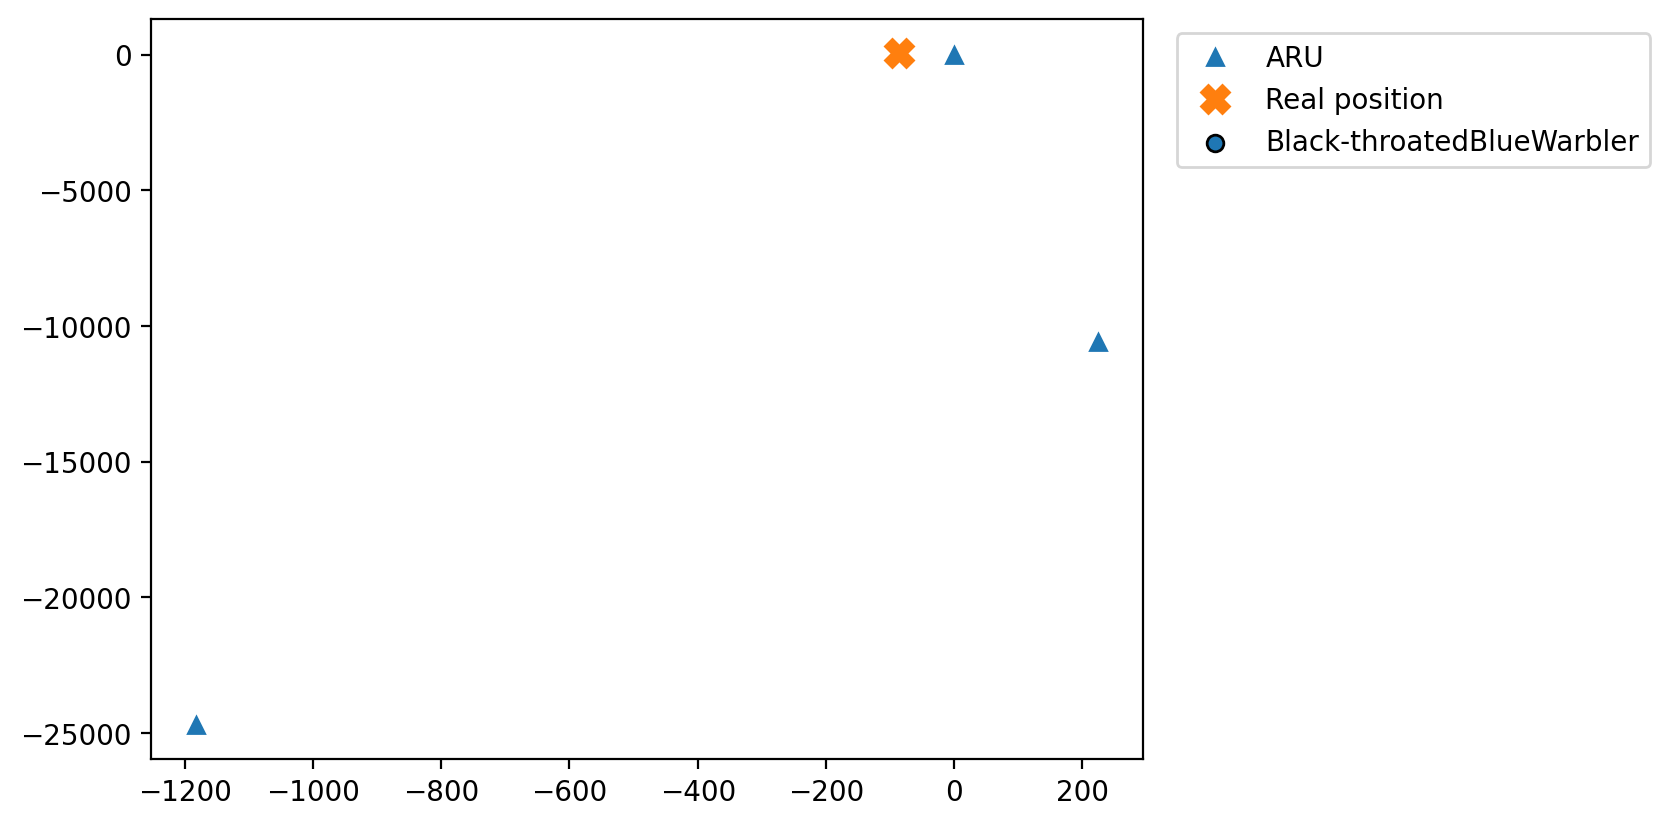

In [ ]:
# filter out estimates with high residuals, keep only position estimates with <5m rms residual
low_rms = [
    e for e in black_throated_blue_warblers if e.residual_rms < 5
]  # get only the events with low residual rms

# plot the ARU locations
plt.plot(aru_coords["x"], aru_coords["y"], "^", label="ARU")
# plot the ARU locations
plt.plot(-86.440, 58.861, "X", markersize=10, label="Real position")
# plot the estimated locations
plt.scatter(
    [e.location_estimate[0] for e in low_rms],
    [e.location_estimate[1] for e in low_rms],
    edgecolor="black",
    label="Black-throatedBlueWarbler",
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

##### Inspect alignment
Let's inspect the alignment of the target sound based on the tdoas for this localized position with low residual error

Here we can see that the Black-throated Blue warbler song at the beginning is properly aligned across all files, indicating that the cross-correlation correctly estimated time delays across recorders. 

In [180]:
audio_segments = low_rms[0].load_aligned_audio_segments()
specs = [Spectrogram.from_audio(a).bandpass(3000, 7000) for a in audio_segments]
plt.pcolormesh(np.vstack([s.spectrogram for s in specs]), cmap="Greys")

IndexError: list index out of range

## Tune localization parameters
There are also a number of parameters you might wish to experiment with, or tune to try and optimize your results. This includes only returning the localized positions with low error, like we did manually above.

- `cc_filter` : The filter applied to the signals cross-correlation. Depending on the acoustic properties of your setting, a different filter may improve TDOA estimation.
- `cc_threshold` : When estimating the TDOA, we find the time-delay that maximizes cross-correlation. You can filter out TDOAs estimated from only poorly-matching audio by increasing the `cc_threshold`. The `cc_threshold` you choose to use will also depend on the `cc_filter` used.
- `residual_threshold` : Once a location is estimated from the TDOAs, you will want to filter out positions that poorly match the observed TDOAs. Setting a low `residual_threshold` will do this.
- `bandpass_ranges` : The frequency ranges to bandpass your audio to before estimating TDOAs. This helps improve time-delay estimation.
- `localization_algorithm` : There are multiple ways to try and solve the location from a set of TDOAs. We have implemented both the Gillette & Silverman algorithm & Soundfinder (GPS) algorithm


In [ ]:
# parameters for localization
min_n_receivers = 4  #
max_receiver_dist = 100  #

# paramaters that can be tuned to increase the accuracy of the localization
bandpass_ranges = {
    "Black-throatedBlueWarbler": [5000, 10000],
    "ScarletTanager": [1000, 5000],
    "Black-throatedGreenWarbler": [5000, 10000],
    "Black-and-whiteWarbler": [5000, 10000],
    "AcadianFlycatcher": [2000, 7000],
}

# phase transform cross-correlation
cc_filter = "phat"
# threshold for TDOA residual rms, in meters. TDOAs with a higher rms residual than this will be discarded
residual_threshold = 5
# threshold for cross-correlation score.
# TDOAs with a lower CC than this will be discarded.
# Can be increased to increase precision at the cost of recall
cc_threshold = 0.01
# options: 'soundfinder', 'gillette', 'least_squares'
localization_algorithm = "gillette"

position_estimates = array.localize_detections(
    detections,
    min_n_receivers=min_n_receivers,
    max_receiver_dist=max_receiver_dist,
    localization_algorithm=localization_algorithm,
    cc_threshold=cc_threshold,
    cc_filter=cc_filter,
    residual_threshold=residual_threshold,
)

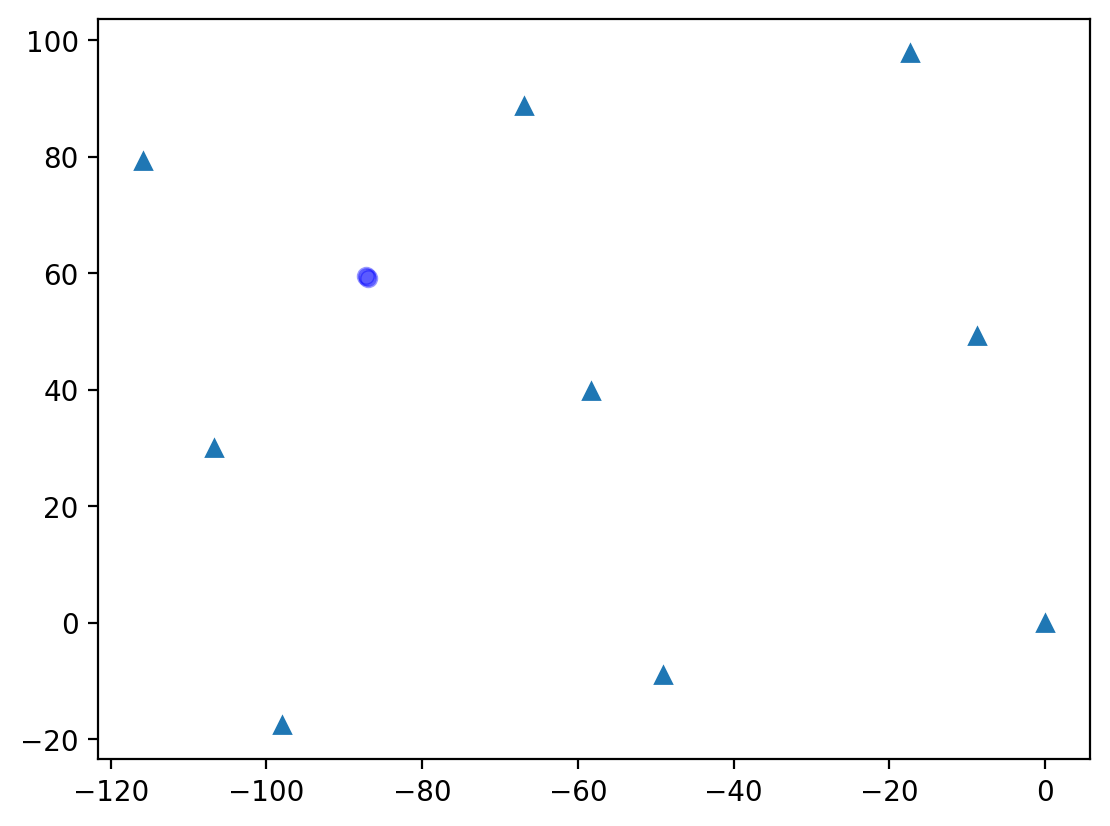

In [ ]:
# get all the SpatialEvents attributed to Black-throatedBlueWarbler
black_throated_blue_warblers = [
    e
    for e in position_estimates
    if e.class_name == "Black-throatedBlueWarbler"
    and e.start_timestamp == example.start_timestamp
]

# get the x-coordinates of the estimated locations
x_coords = [e.location_estimate[0] for e in black_throated_blue_warblers]

# get the y-coordinates of the estimated locations
y_coords = [e.location_estimate[1] for e in black_throated_blue_warblers]

# plot the estimated locations
plt.scatter(
    x_coords, y_coords, color="blue", label="Black-throatedBlueWarbler", alpha=0.4
)

# plot the ARU locations
plt.plot(aru_coords["x"], aru_coords["y"], "^", label="ARU")

**Clean up:** Uncomment and run the following cell to delete the files you downloaded.

In [ ]:
# from pathlib import Path
# for p in Path(".").glob("R*_callibrated.WAV"):
#     p.unlink()
# Path("aru_coords.csv").unlink()
# Path("detections.csv").unlink()